# <a>PROBLEM STATEMENT

What are the things that a potential home buyer considers before purchasing a house?<b> The location, the size of the property, vicinity to offices, schools, parks, restaurants, hospitals or the stereotypical white picket fence? What about the most important factor — the price?</b>
    
Now with the lingering impact of demonetization, the enforcement of the Real Estate (Regulation and Development) Act (RERA), and the lack of trust in property developers in the city, housing units sold across India in 2017 dropped by 7 percent. In fact, the property prices in Bengaluru fell by almost 5 percent in the second half of 2017, said a study published by property consultancy Knight Frank.
    
For example, for a potential homeowner, over 9,000 apartment projects and flats for sale are available in the range of ₹42-52 lakh, followed by over 7,100 apartments that are in the ₹52-62 lakh budget segment, says a report by property website Makaan. According to the study, there are over 5,000 projects in the ₹15-25 lakh budget segment followed by those in the ₹34-43 lakh budget category.
    
Buying a home, especially in a city like Bengaluru, is a tricky choice. While the major factors are usually the same for all metros, there are others to be considered for the Silicon Valley of India. With its help millennial crowd, vibrant culture, great climate and a slew of job opportunities, it is difficult to ascertain the price of a house in Bengaluru.



# <a>1. Import libraries and load the data

In [1]:
# necessary libraries
import pandas as pd
import numpy as np
import os

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stat
import pylab

In [2]:
os.chdir(os.getcwd() + "\\Data")
os.listdir()

['House price prediction.docx', 'housepred.csv']

In [3]:
house_data = pd.read_csv("housepred.csv", index_col = 0)

In [4]:
df = house_data.copy()
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 1.0+ MB


In [6]:
l = df["size"].value_counts().index
d = dict()
for i in l:
    d[i] = int(i.split()[0])
df["size"] = df["size"].map(d)

In [7]:
a = set()
for i in df["total_sqft"]:
    try: 
        float(i)
    except:
        a.add(i)
        
b = []
for i in a:
    
    try:
        s = i.split()
        if (s[1] == "-"):
            b.append((i, round((float(s[0]) + float(s[2]))/2, 2)))
            
        if (s[1] == "Meter"):
            b.append((i, round(float(s[0][:-3]) * 10.764, 2)))
            
        if (s[1] == "Yards"):
            b.append((i, round(float(s[0][:-3]) * 9, 2)))
            
    except:
        
        if "Acres" in i:
            b.append((i, round(float(i.split("A")[0]) * 43560, 2)))

        elif "Grounds" in i:
            b.append((i, round(float(i.split("G")[0]) * 2400, 2)))

        elif "Perch" in i:
            b.append((i, round(float(i.split("P")[0]) * 272.25, 2)))

        elif "Guntha" in i:
            b.append((i, round(float(i.split("G")[0]) * 1089, 2)))

        else:
            b.append((i, round(float(i.split("C")[0]) * 435.6, 2)))

In [8]:
d = dict()
for i in b:
    d[i[0]] = i[1]
    
df["total_sqft"] = df["total_sqft"].replace(list(d.keys()), list(d.values()))
df["total_sqft"] = df["total_sqft"].astype("float64")

In [9]:
from datetime import date

today = date.today()
today_date = today.strftime("%d/%m/%Y")
today_date_time = str(pd.to_datetime(today_date))
year = today_date_time[:4]

d = dict()
for i in df["availability"]:
   
    if (i == "Ready To Move"):
        d[i] = today_date_time
        
    elif (i == "Immediate Possession"):
        d[i] = today_date_time
    
    else:
        d[i] = (i + "-" + year)
        
df["availability"] = df["availability"].map(d)
df["availability"] = pd.to_datetime(df["availability"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   area_type     13320 non-null  object        
 1   availability  13320 non-null  datetime64[ns]
 2   location      13319 non-null  object        
 3   size          13304 non-null  float64       
 4   society       7818 non-null   object        
 5   total_sqft    13320 non-null  float64       
 6   bath          13247 non-null  float64       
 7   balcony       12711 non-null  float64       
 8   price         13320 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 1.0+ MB


In [11]:
def missing_value_percentage(df):
    
    mis_values = df.isnull().sum()
    
    percentage = 100 * df.isnull().sum() / len(df)
    
    new_df = pd.concat([mis_values, percentage], axis = 1)
    new_df.columns = ["missing values", "percentage"]
    
    sorted_df = new_df[new_df.iloc[:,1] != 0].sort_values("percentage" ,ascending = False)
    
    return (sorted_df)
missing_value_percentage(df)

,missing values,percentage
society,5502,41.306306
balcony,609,4.572072
bath,73,0.548048
size,16,0.120120
location,1,0.007508


In [12]:
df.drop("society", axis = 1, inplace = True)

# <a>2. Handeling Categorical Features

In [118]:
df_ob = df.select_dtypes("object")
df_num = df.drop(df_ob, axis = 1)

for i in df_ob:
    print(i, df_ob[i].nunique())

area_type 4
location 1305


## <a>2.1 One Hot Encoding

In [15]:
df_HE = pd.DataFrame(df_ob["area_type"])
df_HE = pd.get_dummies(df_HE)
df_HE.head()

,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0,0,0,1
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


## <a>2.2 Some categories from column

In [16]:
df_top = pd.DataFrame(df_ob["location"])

In [17]:
df_top["location"].value_counts().head(10)

Whitefield               540
Sarjapur  Road           399
Electronic City          302
Kanakpura Road           273
Thanisandra              234
Yelahanka                213
Uttarahalli              186
Hebbal                   177
Marathahalli             175
Raja Rajeshwari Nagar    171
Name: location, dtype: int64

In [18]:
location_10 = [x for x in df_top["location"].value_counts().head(10).index]

for i in location_10:
    df_top[i] = np.where(df_top["location"] == i,1,0)
    
df_top.drop("location", axis = 1, inplace = True)
df_top.head()

,Whitefield,Sarjapur Road,Electronic City,Kanakpura Road,Thanisandra,Yelahanka,Uttarahalli,Hebbal,Marathahalli,Raja Rajeshwari Nagar
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


## <a>2.3 Mean Encoding

In [19]:
df_ME = df_ob.copy()

In [20]:
df_ME["price"] = df["price"]
for i in df_ME:
    df_mean = df_ME.groupby([i])["price"].mean().to_dict()
    df_ME[i] = df_ME[i].map(df_mean)
df_ME.head()

,area_type,location,price
0,92.971757,48.316667,39.07
1,208.495486,115.015882,120.00
2,104.285498,61.252527,62.00
3,92.971757,115.348261,95.00
4,92.971757,95.630303,51.00


In [21]:
for i in df_ob:
    print(i, df_ob[i].nunique(), df_ME[i].nunique())

area_type 4 4
location 1305 855


## <a>2.4 Final Concatenation

In [22]:
df_new = pd.concat([df_ME["area_type"], df_top, df_num], axis = 1)
df_new.head()

,area_type,Whitefield,Sarjapur Road,Electronic City,Kanakpura Road,Thanisandra,Yelahanka,Uttarahalli,Hebbal,Marathahalli,Raja Rajeshwari Nagar,availability,size,total_sqft,bath,balcony,price
0,92.971757,0,0,0,0,0,0,0,0,0,0,2021-12-19,2.0,1056.0,2.0,1.0,39.07
1,208.495486,0,0,0,0,0,0,0,0,0,0,2021-01-27,4.0,2600.0,5.0,3.0,120.00
2,104.285498,0,0,0,0,0,0,1,0,0,0,2021-01-27,3.0,1440.0,2.0,3.0,62.00
3,92.971757,0,0,0,0,0,0,0,0,0,0,2021-01-27,3.0,1521.0,3.0,1.0,95.00
4,92.971757,0,0,0,0,0,0,0,0,0,0,2021-01-27,2.0,1200.0,2.0,1.0,51.00


# <a>3. Handeling Missing / Null Values

In [23]:
missing_value_percentage(df_new)

,missing values,percentage
balcony,609,4.572072
bath,73,0.548048
size,16,0.120120


In [24]:
a = df_new.isnull().sum() > 0
b = pd.DataFrame(a)
b.reset_index(level = 0,inplace = True)
b.columns = ["att","bool"]
c = b.loc[b["bool"] == True, "att"]
c        

12       size
14       bath
15    balcony
Name: att, dtype: object

In [25]:
def distplot(df, df_new):
    plt.figure(figsize = (18,18))
    plotnumber = 1
    for i in c:
        ax = plt.subplot(3,1,plotnumber)
        df[i].plot(kind='kde', ax = ax)
        df_new[i].plot(kind='kde', ax = ax, color = 'red')
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc = 'best')
        plotnumber += 1
    plt.show()

## <a>3.1 Mean/ Median Imputation Or Skewness factor

In [26]:
df_SF = df_new.copy()
df_SF.drop("availability", axis = 1, inplace = True)

In [27]:
def skewness(df):
    sk=[]
    for i in df:
        sk1 = (df[i].mean() - df[i].mode())/df[i].std()
        sk.append(sk1)
        
    SK1 = pd.DataFrame(sk, columns = ["skewness"])
    
    j = 0
    for i in df.columns:
        if j < len(SK1):
            if SK1["skewness"][j] > .5:
                df[i] = df[i].fillna(df[i].median())
                
            elif SK1["skewness"][j] < -0.5:
                df[i] = df[i].fillna(df[i].median())
                
            else:
                df[i] = df[i].fillna(df[i].mean())
            j += 1

    return(df)

df_SF = skewness(df_SF)
df_SF.isnull().sum()

area_type                0
Whitefield               0
Sarjapur  Road           0
Electronic City          0
Kanakpura Road           0
Thanisandra              0
Yelahanka                0
Uttarahalli              0
Hebbal                   0
Marathahalli             0
Raja Rajeshwari Nagar    0
size                     0
total_sqft               0
bath                     0
balcony                  0
price                    0
dtype: int64

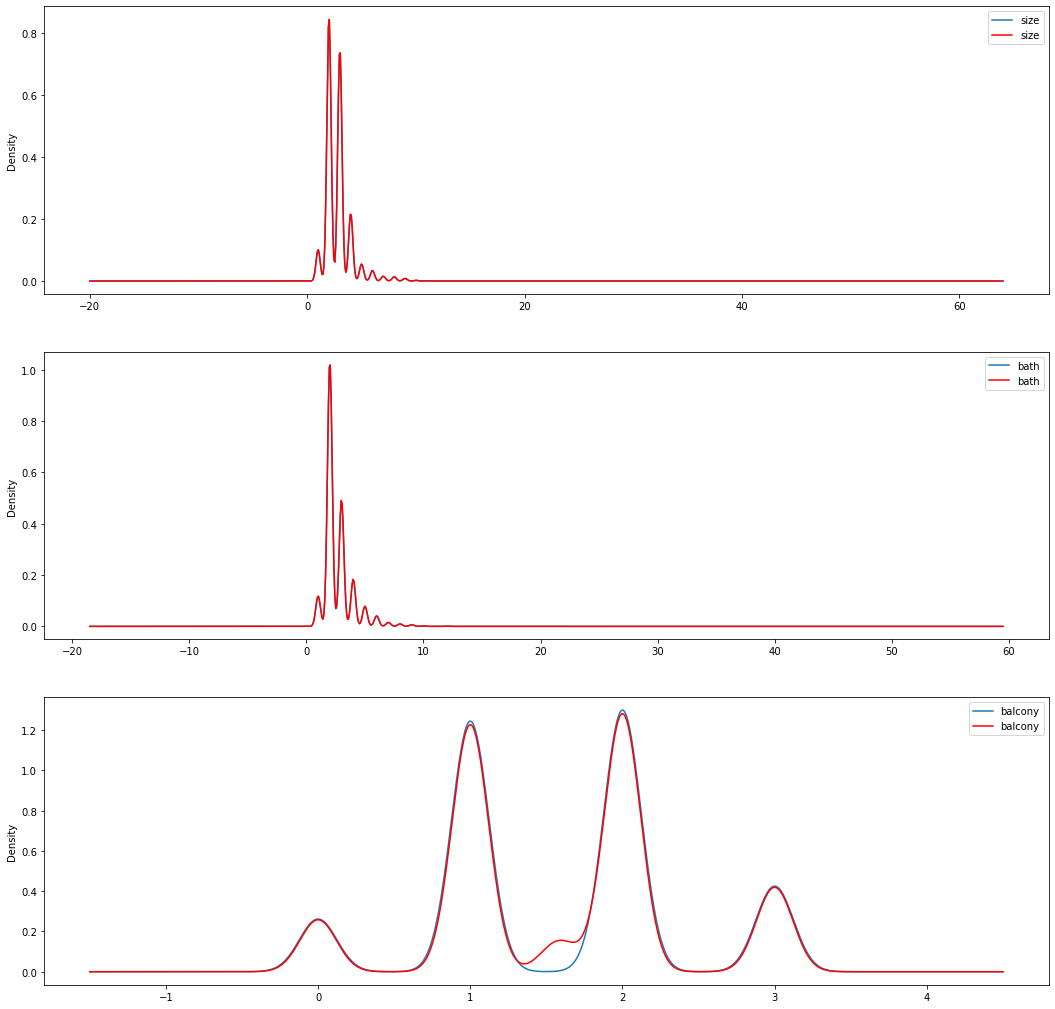

In [28]:
distplot(df_new, df_SF)

## <a>3.2 Variance Method Replacement

In [29]:
df_VM = df_new.copy()

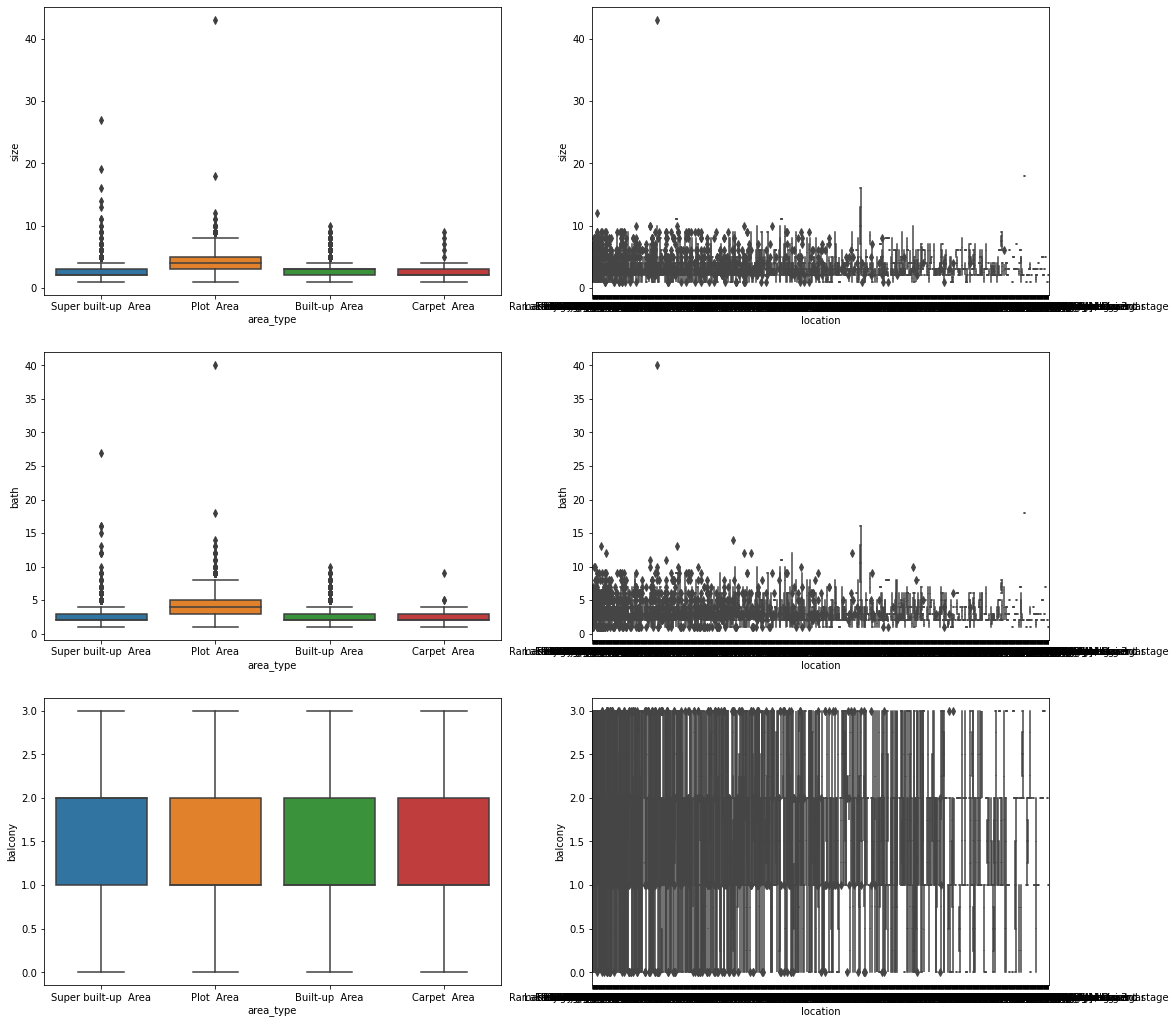

In [30]:
plt.figure(figsize = (18,18))
plotnumber = 1
for i in c:
    for j in df_ob: 
        if plotnumber <= 6:
            ax = plt.subplot(3,2,plotnumber)
            sns.boxplot(y = df_VM[i],x = df_ob[j])
            plt.xlabel(j)
            plt.ylabel(i)
            plotnumber += 1
plt.show()        

In [31]:
for i in c:
    for j in df_ob:
        a = df_VM.groupby(df_ob[j])[i].mean()
        print(a, "\n\n")

area_type
Built-up  Area          2.791563
Carpet  Area            2.666667
Plot  Area              4.060229
Super built-up  Area    2.521274
Name: size, dtype: float64 


location
 Anekal                 1.000000
 Banaswadi              1.000000
 Basavangudi            1.000000
 Bhoganhalli            1.000000
 Devarabeesana Halli    2.666667
                          ...   
t.c palya               6.000000
tc.palya                2.250000
vinayakanagar           7.000000
white field,kadugodi    6.000000
whitefiled              2.000000
Name: size, Length: 1305, dtype: float64 


area_type
Built-up  Area          2.649378
Carpet  Area            2.505747
Plot  Area              3.893479
Super built-up  Area    2.430386
Name: bath, dtype: float64 


location
 Anekal                 1.000000
 Banaswadi              1.000000
 Basavangudi            1.000000
 Bhoganhalli            1.000000
 Devarabeesana Halli    2.666667
                          ...   
t.c palya               6.000000


In [32]:
for i in c:
    df_VM[i] = df_VM.groupby(df_ob["area_type"])[i].apply(lambda x : x.fillna(x.mean()))

df_VM.isnull().sum()

area_type                0
Whitefield               0
Sarjapur  Road           0
Electronic City          0
Kanakpura Road           0
Thanisandra              0
Yelahanka                0
Uttarahalli              0
Hebbal                   0
Marathahalli             0
Raja Rajeshwari Nagar    0
availability             0
size                     0
total_sqft               0
bath                     0
balcony                  0
price                    0
dtype: int64

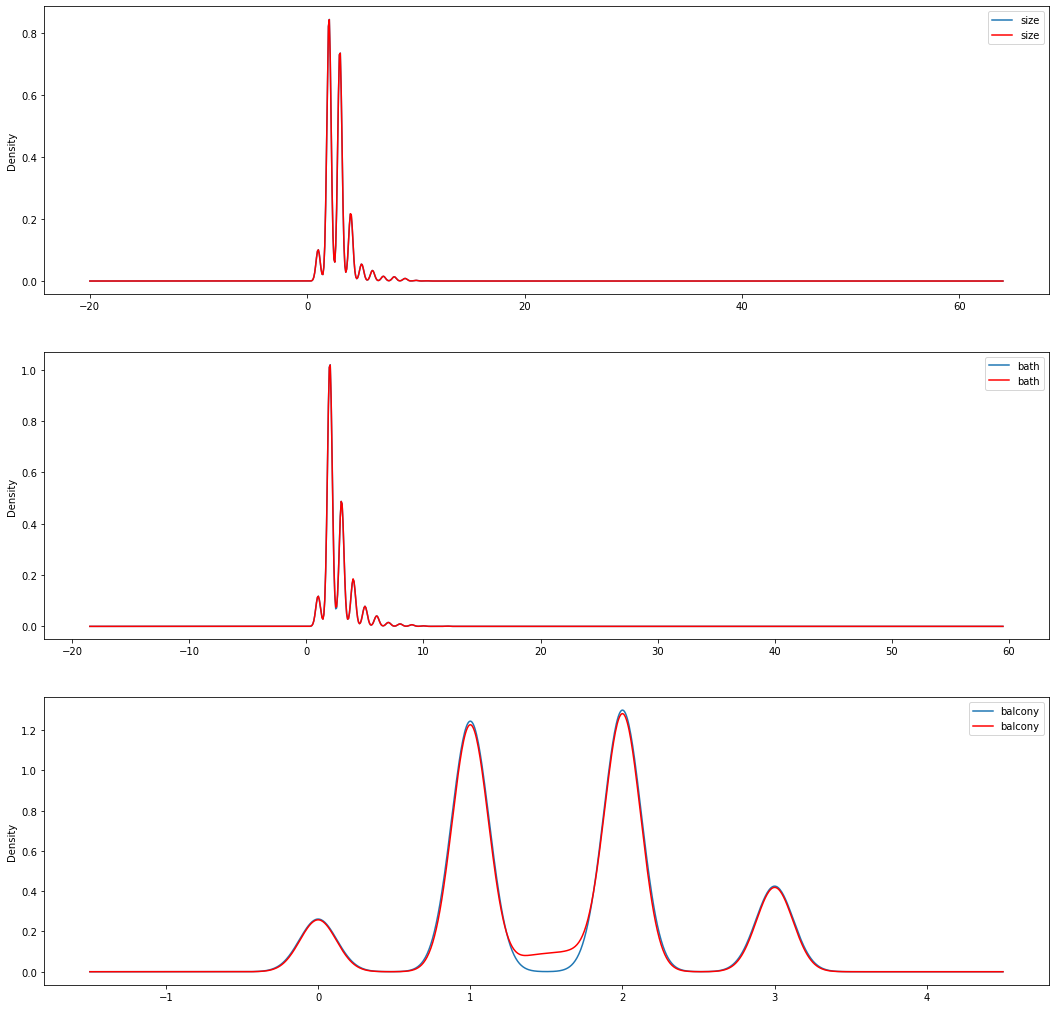

In [33]:
distplot(df_new, df_VM)

## <a>3.3 Iterative Imputer

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [35]:
df_II = df_new.copy()
df_II.drop("availability", axis = 1, inplace = True)

In [36]:
impute = IterativeImputer()
df_impute = impute.fit_transform(df_II)
df_impute = pd.DataFrame(df_impute, columns = df_II.columns)
df_impute.isnull().sum()

area_type                0
Whitefield               0
Sarjapur  Road           0
Electronic City          0
Kanakpura Road           0
Thanisandra              0
Yelahanka                0
Uttarahalli              0
Hebbal                   0
Marathahalli             0
Raja Rajeshwari Nagar    0
size                     0
total_sqft               0
bath                     0
balcony                  0
price                    0
dtype: int64

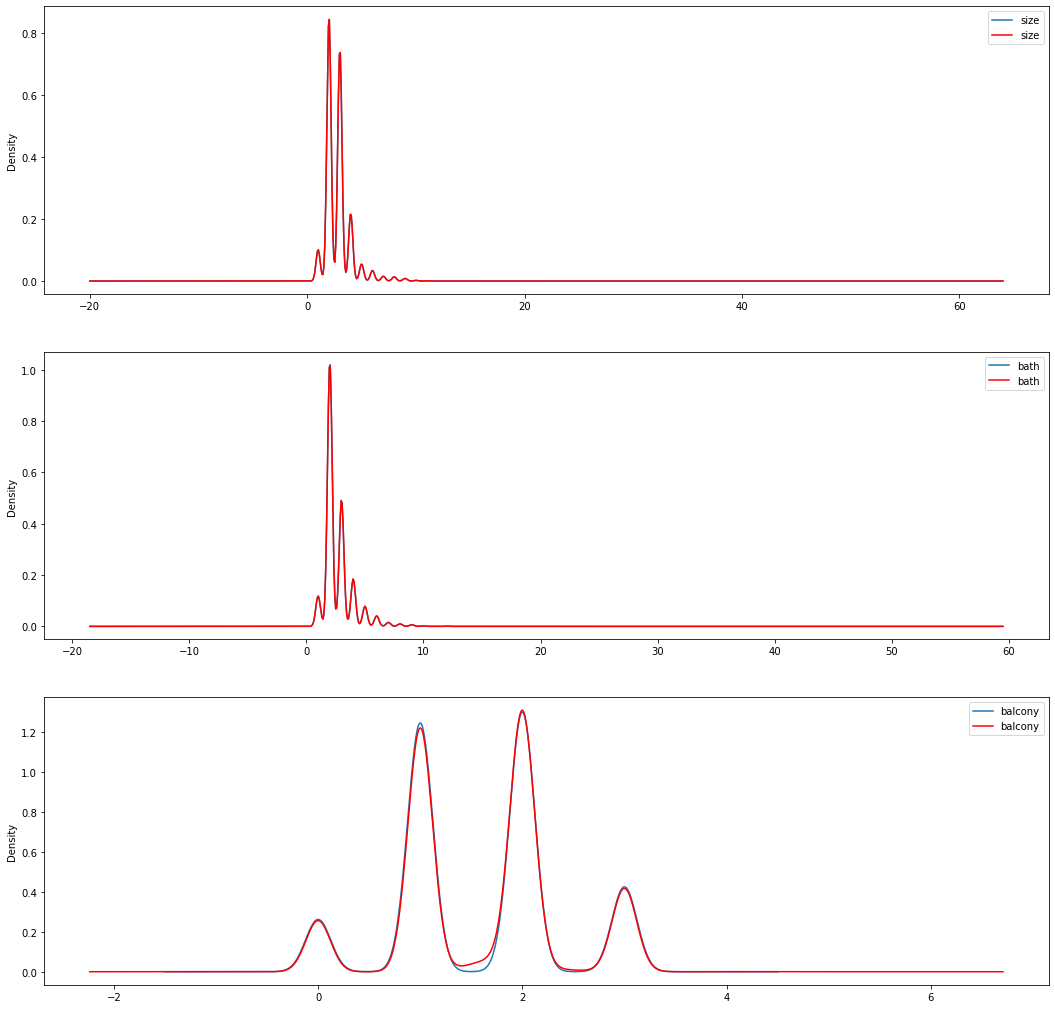

In [37]:
distplot(df_new, df_impute)

## <a>3.4 KNN Imputer

In [38]:
from sklearn.impute import KNNImputer

In [39]:
df_KNN = df_new.copy()
df_KNN.drop("availability", axis = 1, inplace = True)

In [40]:
impute = KNNImputer(n_neighbors = 2)
df_impute = impute.fit_transform(df_KNN)
df_impute = pd.DataFrame(df_impute, columns = df_KNN.columns)
df_impute.head()

,area_type,Whitefield,Sarjapur Road,Electronic City,Kanakpura Road,Thanisandra,Yelahanka,Uttarahalli,Hebbal,Marathahalli,Raja Rajeshwari Nagar,size,total_sqft,bath,balcony,price
0,92.971757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1056.0,2.0,1.0,39.07
1,208.495486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2600.0,5.0,3.0,120.00
2,104.285498,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1440.0,2.0,3.0,62.00
3,92.971757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1521.0,3.0,1.0,95.00
4,92.971757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1200.0,2.0,1.0,51.00


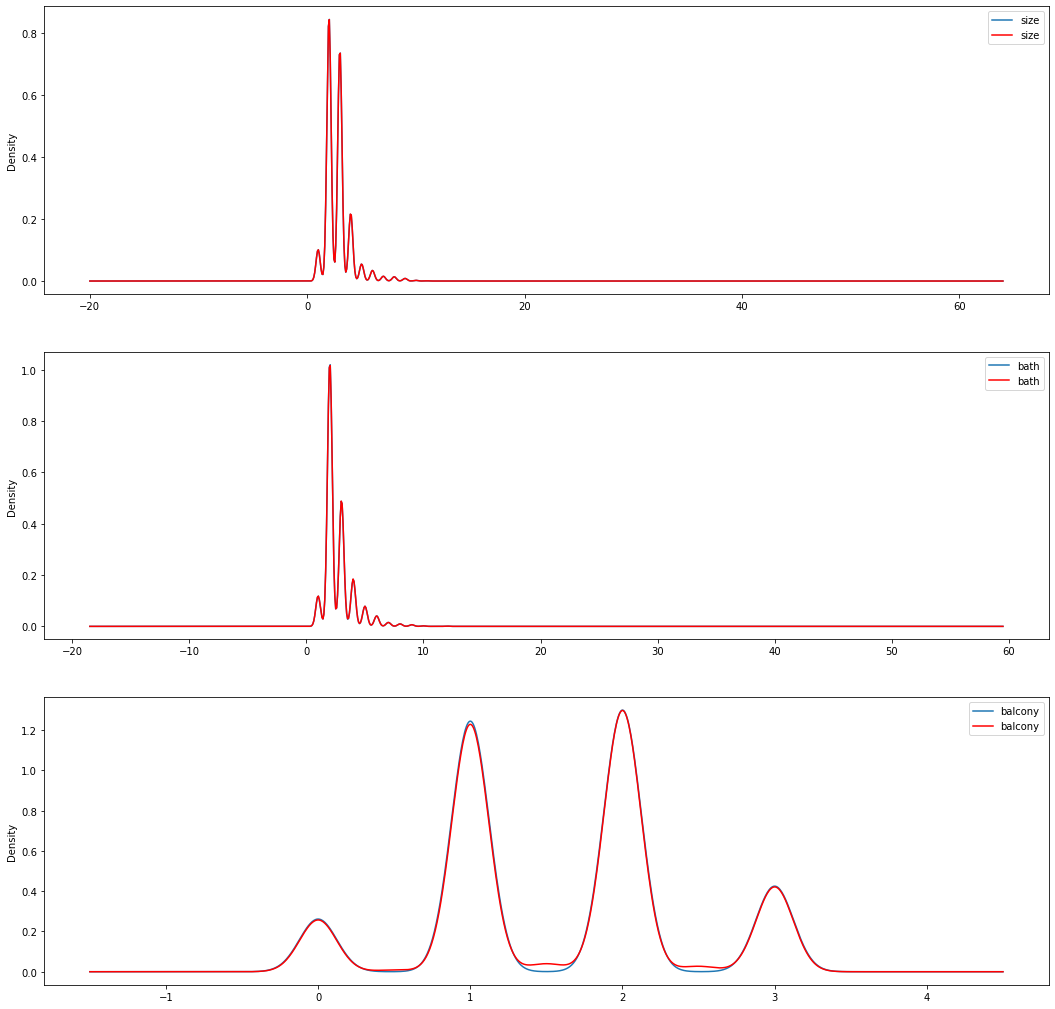

In [41]:
distplot(df_new, df_impute)

## <a>3.5 Best Filling - By Variance Method

In [42]:
df_new = df_VM.copy()
df_new.isnull().sum()

area_type                0
Whitefield               0
Sarjapur  Road           0
Electronic City          0
Kanakpura Road           0
Thanisandra              0
Yelahanka                0
Uttarahalli              0
Hebbal                   0
Marathahalli             0
Raja Rajeshwari Nagar    0
availability             0
size                     0
total_sqft               0
bath                     0
balcony                  0
price                    0
dtype: int64

# <a>4. Outliers Treatment

In [43]:
df_out = df_new[["size", "total_sqft", "bath", "balcony", "price"]]

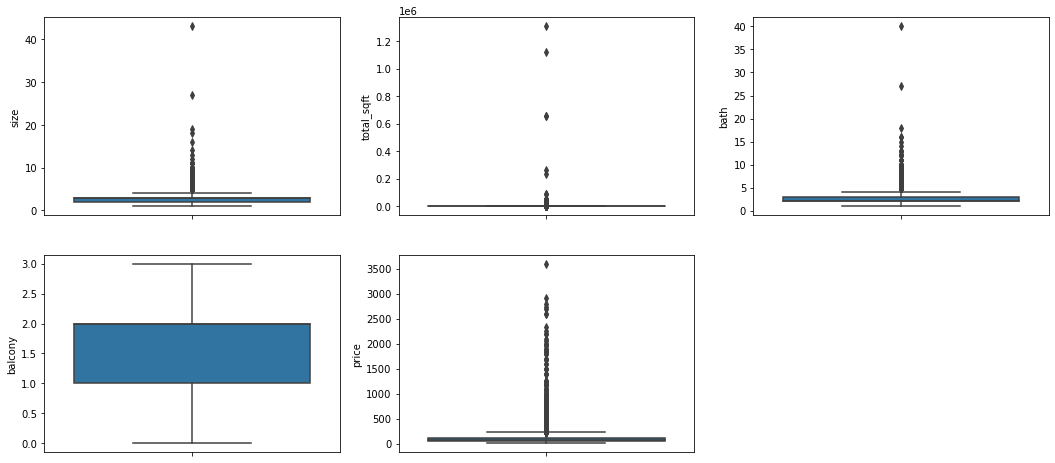

In [44]:
def distplot(data):
    plt.figure(figsize = (18,8))
    plotnumber = 1
    for i in data:
        ax = plt.subplot(2,3,plotnumber)
        sns.distplot(data[i])
        plt.xlabel(i,fontsize = 20)
        plotnumber += 1
    plt.show()

def QQplot(data):
    for i in data:
        plt.figure(figsize = (14,5))
        plt.subplot(1,2,1)
        data[i].hist()
        plt.subplot(1,2,2)
        stat.probplot(data[i],dist = 'norm',plot = pylab)
        plt.xlabel(i)
        plt.show()

def boxplot(data):
    plt.figure(figsize = (18,8))
    plotnumber = 1
    for i in data:
        ax = plt.subplot(2,3,plotnumber)
        sns.boxplot(y = data[i])
        plotnumber += 1
    plt.show()
boxplot(df_out)

## <a>4.1 Quantile Method

In [45]:
df_QM = df_out.copy()

In [46]:
def outliers(data):
    lw = []
    ow = []
    for i in data.columns:
        q1,q3 = data[i].quantile([.25,.75])
        lo = q1-1.5*(q3-q1)
        uo = q3+1.5*(q3-q1)
        lw.append(lo)
        ow.append(uo)

    j = 0 
    for i in data:
        if j < len(lw):
            data.loc[data[i] <= lw[j],i] = lw[j]
            data.loc[data[i] >= ow[j],i] = ow[j]
        j += 1

    return(data)

df_QM = outliers(df_QM)

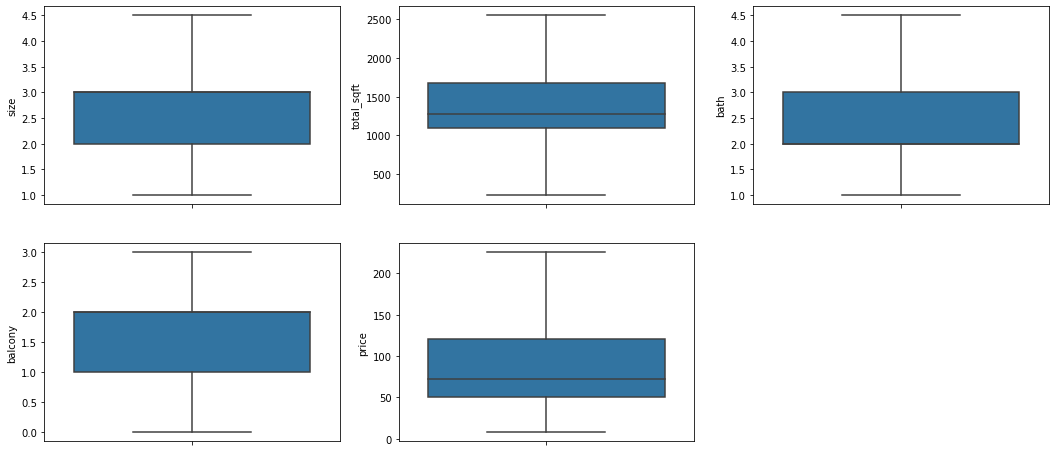

In [47]:
boxplot(df_QM)

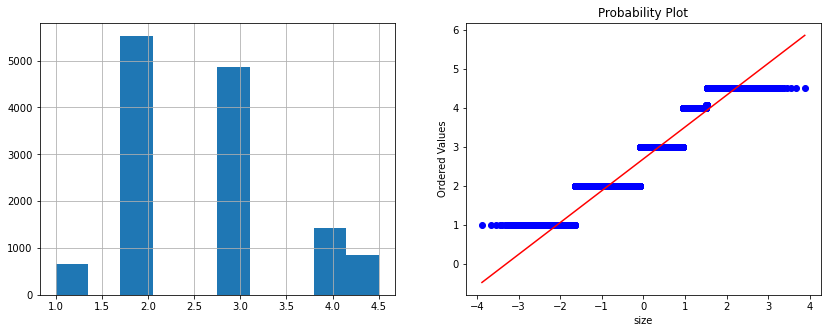

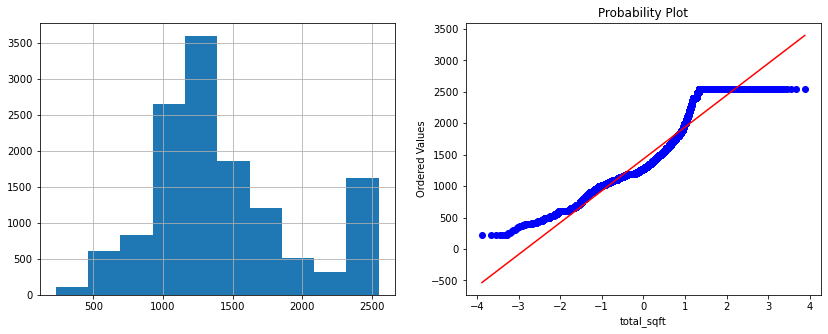

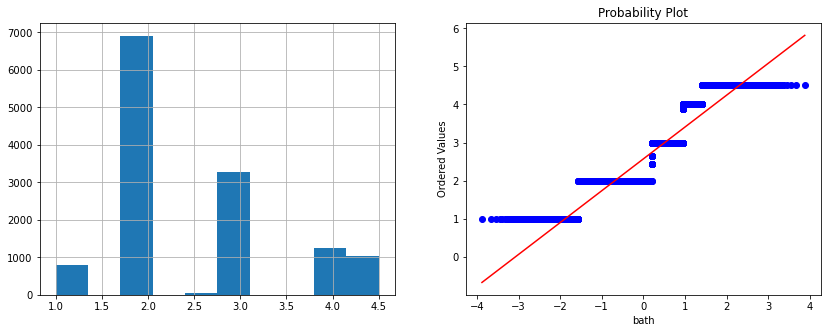

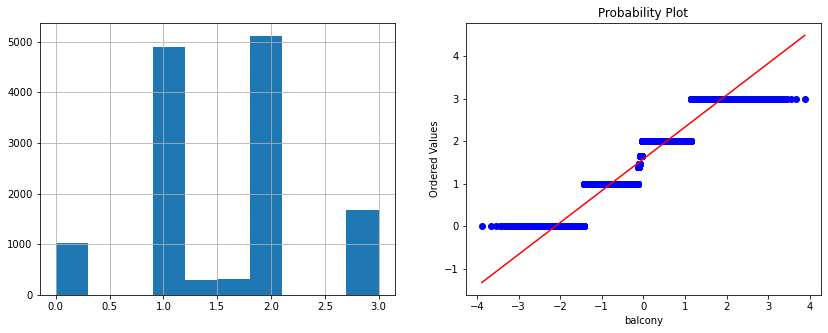

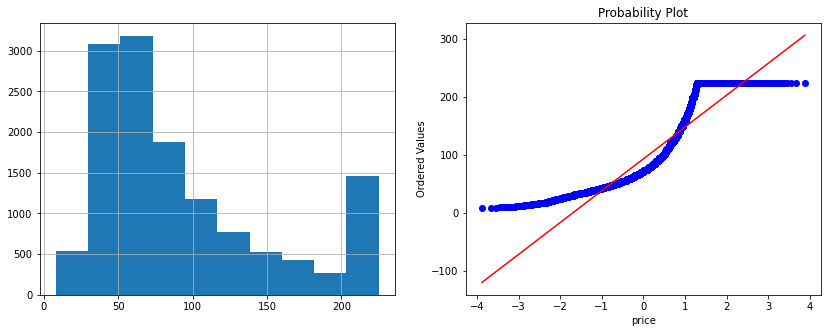

In [48]:
QQplot(df_QM)

## <a>4.2 3-Sigma Method

In [49]:
df_SM = df_out.copy()

H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

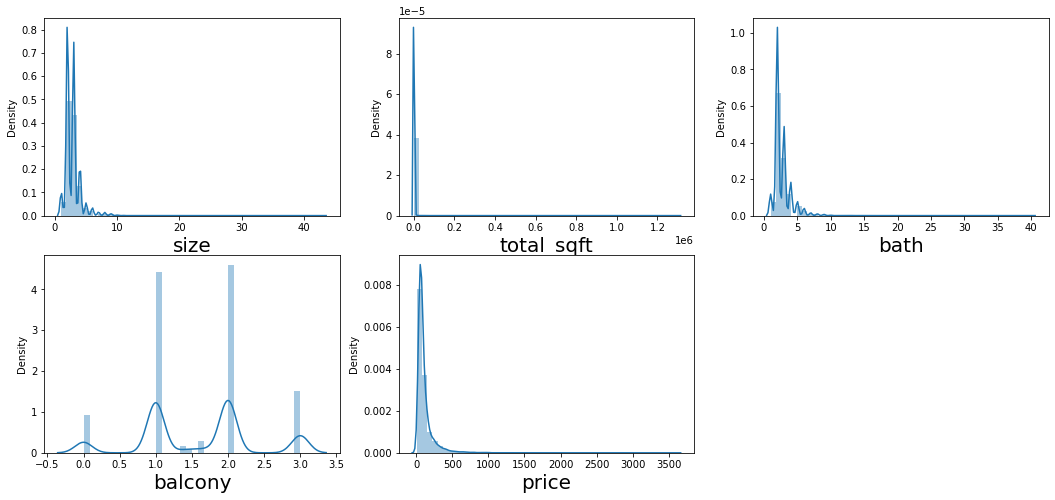

In [50]:
distplot(df_SM)

In [51]:
def sigma_outlier(data):
    min_sigma = []
    max_sigma = []
    for i in data:
        min_3sigma = data[i].mean() - 3*data[i].std()
        max_3sigma = data[i].mean() + 3*data[i].std()
        min_sigma.append(min_3sigma)
        max_sigma.append(max_3sigma)
       
    j=0
    for i in data:
        if j < len(min_sigma):
            data.loc[data[i] <= min_sigma[j],i] = min_sigma[j]
            data.loc[data[i] >= max_sigma[j],i] = max_sigma[j]
        j+=1

    return(data)
df_SM = sigma_outlier(df_SM)

H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

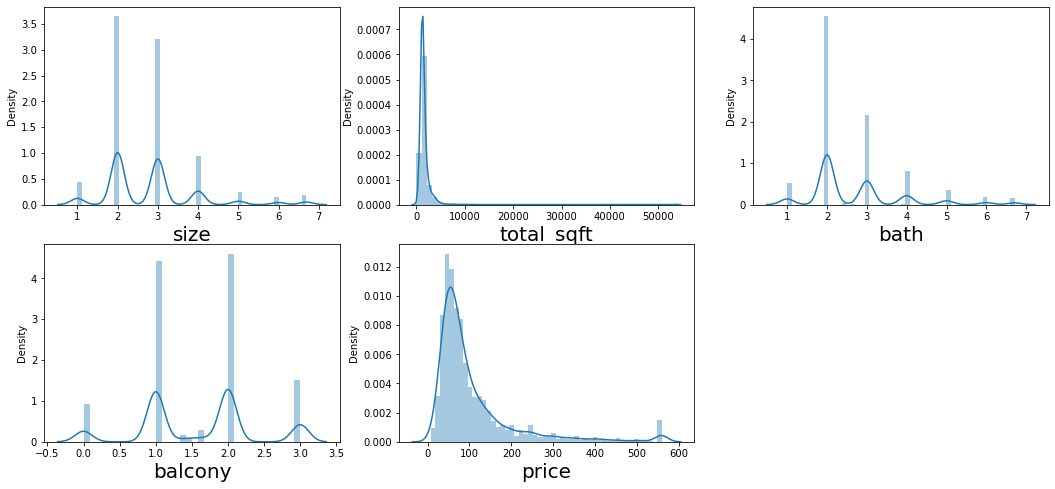

In [52]:
distplot(df_SM)

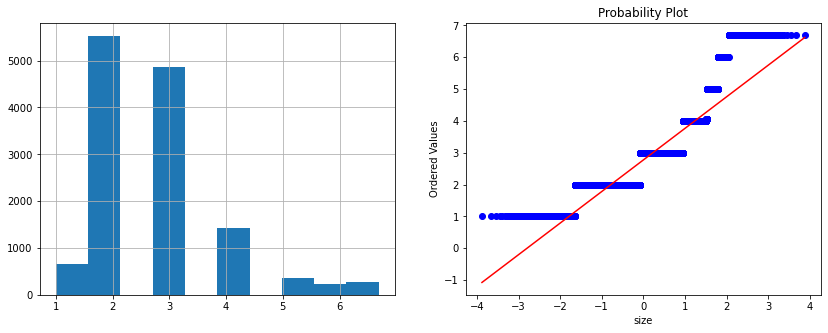

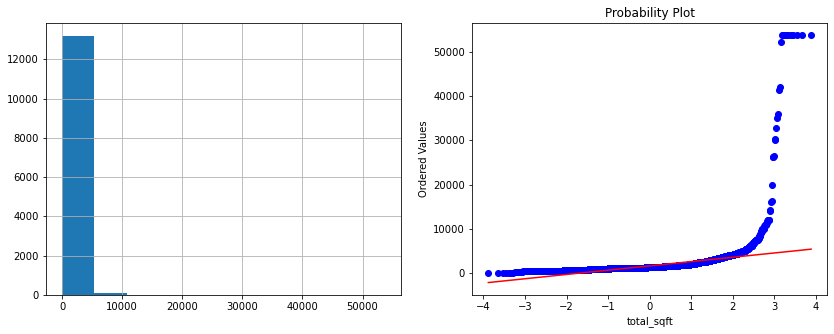

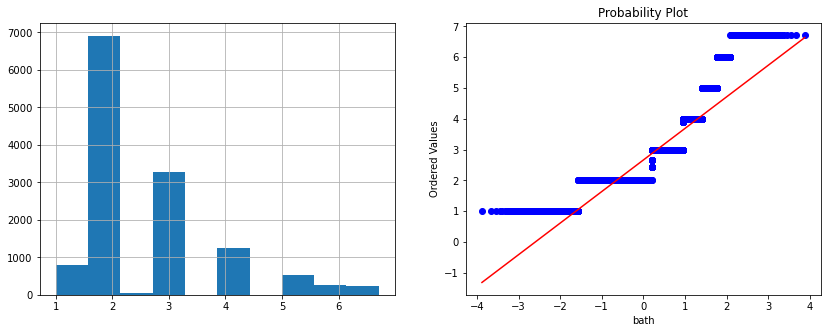

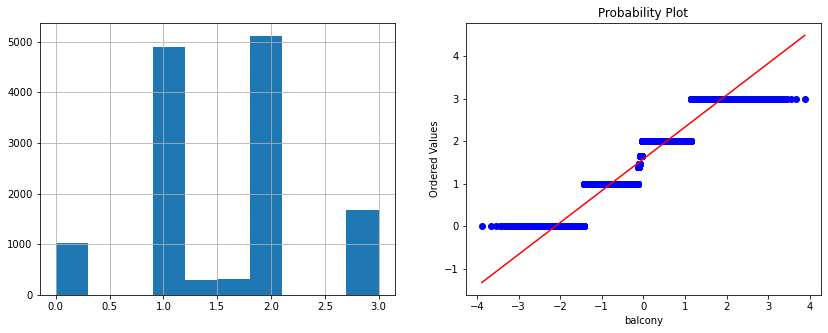

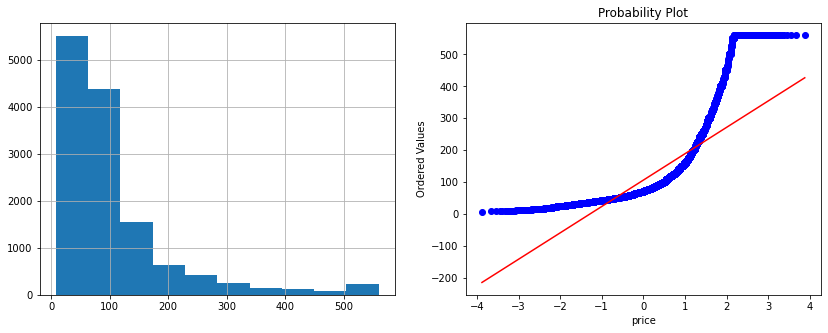

In [53]:
QQplot(df_SM)

## <a>4.3 Isolation Forest

In [54]:
from sklearn.ensemble import IsolationForest

In [55]:
df_IF = df_out.copy()

In [56]:
iso = IsolationForest(contamination = .1, n_estimators = 10000)
my_model = iso.fit(df_IF)
df_IF["outlier"] = my_model.predict(df_IF)
df_IF = df_IF.loc[df_IF["outlier"] == 1]

H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

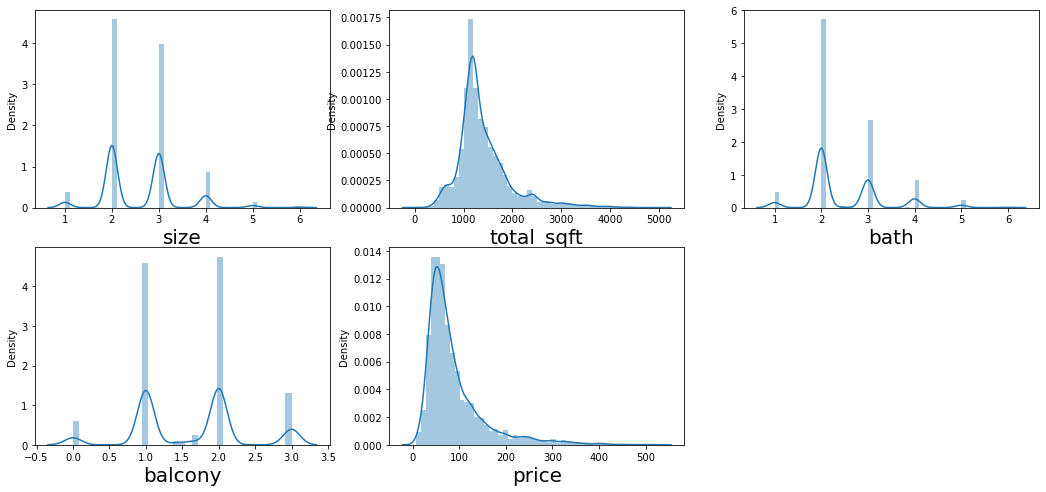

In [57]:
distplot(df_IF.iloc[:,:-1])

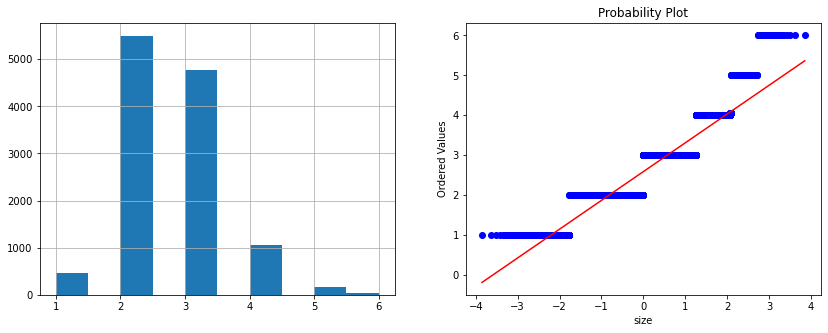

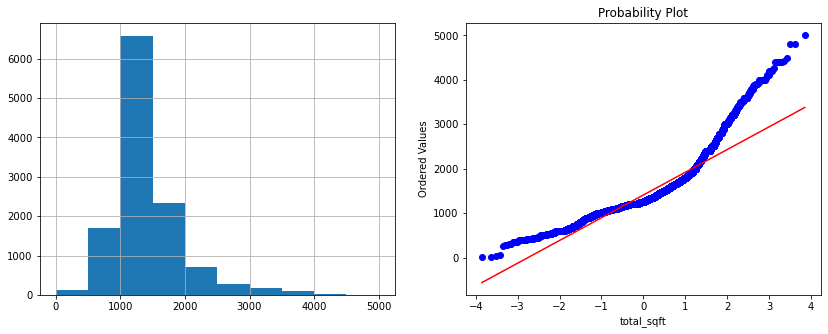

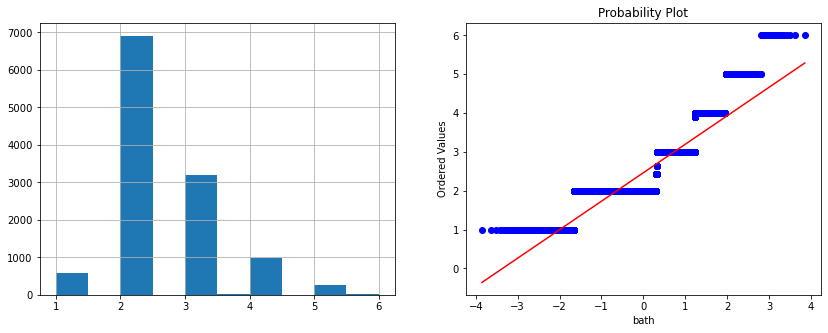

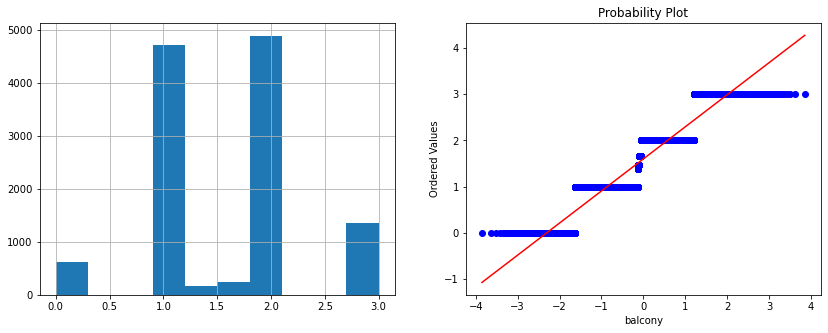

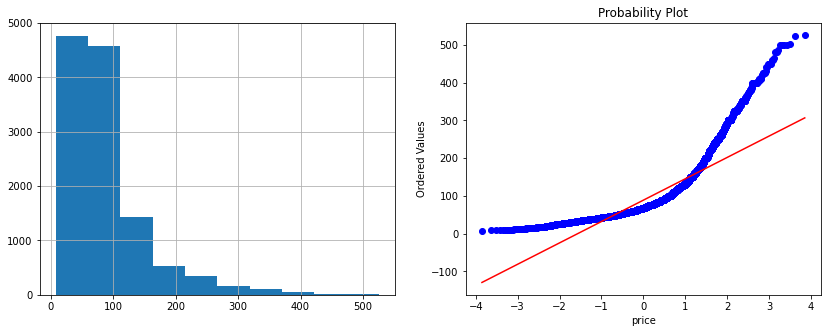

In [58]:
QQplot(df_IF.iloc[:,:-1])

## <a>4.4 Best Method - Quantile Method

In [59]:
df_new.drop(df_out, axis = 1, inplace = True)
df_new = pd.concat([df_new, df_QM], axis = 1)
df_new.head()

,area_type,Whitefield,Sarjapur Road,Electronic City,Kanakpura Road,Thanisandra,Yelahanka,Uttarahalli,Hebbal,Marathahalli,Raja Rajeshwari Nagar,availability,size,total_sqft,bath,balcony,price
0,92.971757,0,0,0,0,0,0,0,0,0,0,2021-12-19,2.0,1056.0,2.0,1.0,39.07
1,208.495486,0,0,0,0,0,0,0,0,0,0,2021-01-27,4.0,2550.0,4.5,3.0,120.00
2,104.285498,0,0,0,0,0,0,1,0,0,0,2021-01-27,3.0,1440.0,2.0,3.0,62.00
3,92.971757,0,0,0,0,0,0,0,0,0,0,2021-01-27,3.0,1521.0,3.0,1.0,95.00
4,92.971757,0,0,0,0,0,0,0,0,0,0,2021-01-27,2.0,1200.0,2.0,1.0,51.00


# <a>5. Feature Selection

In [60]:
df_FS = df_new.copy()

In [61]:
X = df_FS.iloc[:,:-1]
X.drop("availability", axis = 1, inplace = True)
y = df_FS["price"]

In [62]:
def barplot(data):
    plt.figure(figsize = (12,12))
    data.plot(kind = "bar")

## <a>5.1 Filter Method

In [63]:
def Filter(model):
    skb = SelectKBest(score_func = model)
    skb.fit(X,y)
    
    df_score = pd.DataFrame(skb.scores_, columns = ["score"], index = X.columns)

    return(df_score)

### <a>5.1.1 f_regression()

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [65]:
df_f_regression = Filter(f_regression)
df_f_regression

,score
area_type,2033.383858
Whitefield,10.703300
Sarjapur Road,10.374643
Electronic City,139.668555
Kanakpura Road,41.357793
Thanisandra,8.596303
Yelahanka,8.860258
Uttarahalli,58.098654
Hebbal,72.513453
Marathahalli,0.922827


<Figure size 864x864 with 0 Axes>

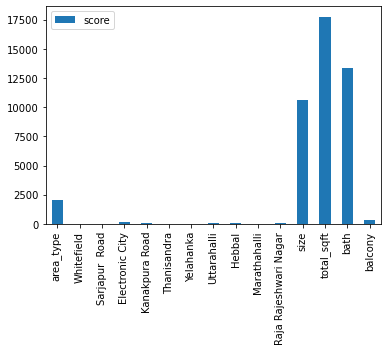

In [66]:
barplot(df_f_regression)

### <a>5.1.2 Correlation

<AxesSubplot:>

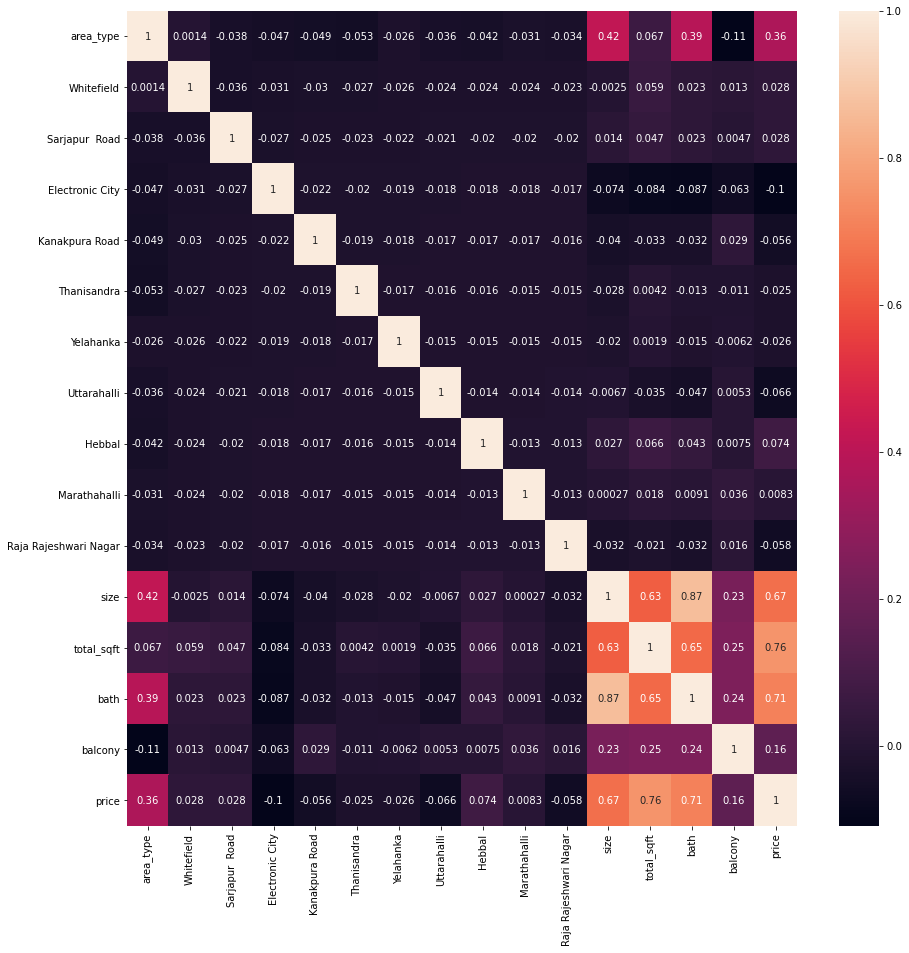

In [67]:
corr = df_FS.iloc[:,:].corr()
top_features = corr.index
plt.figure(figsize = (15,15))
sns.heatmap(df_FS[top_features].corr(),annot = True)

In [68]:
corr_target = abs(corr["price"])
corr_target[corr_target > .5]

size          0.666347
total_sqft    0.755884
bath          0.707636
price         1.000000
Name: price, dtype: float64

In [69]:
threshold = 0.5

def correlation(data, threshold):
    col_corr = set()  
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr
correlation(df_FS.iloc[:,:-1],threshold)

{'bath', 'total_sqft'}

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["column"] = X.columns

vif.sort_values(ascending = False, by = "VIF")

,VIF,column
11,46.219749,size
13,40.634162,bath
12,14.719547,total_sqft
0,8.588354,area_type
14,4.780320,balcony
1,1.057296,Whitefield
2,1.039452,Sarjapur Road
8,1.024351,Hebbal
4,1.023859,Kanakpura Road
7,1.021872,Uttarahalli


## <a>5.2 Wrapper Method (OLS Method)

In [71]:
import statsmodels.api as sm

In [72]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['area_type', 'Whitefield', 'Electronic City', 'Kanakpura Road', 'Thanisandra', 'Yelahanka', 'Uttarahalli', 'Hebbal', 'Raja Rajeshwari Nagar', 'total_sqft', 'bath', 'balcony']


## <a>5.3 Embedded Method

### <a>5.3.1 Lasso Method

In [73]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import SelectFromModel

In [74]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 23.868278
Best score using built-in LassoCV: 0.669739


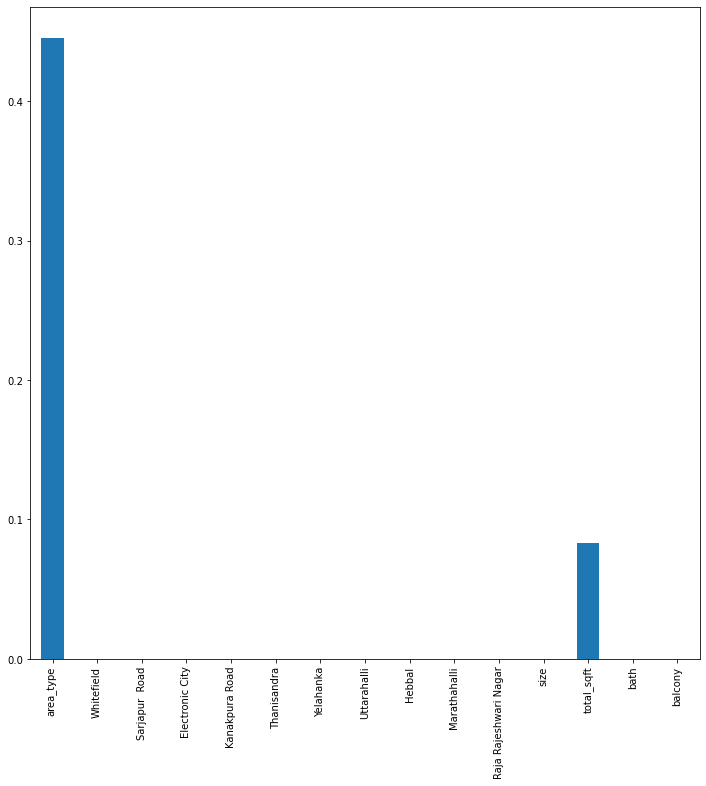

In [75]:
barplot(coef)

In [76]:
ls = SelectFromModel(Lasso(alpha = 23.86, random_state = 0))
ls.fit(X,y)
ls.get_support()

selected_features = X.columns[(ls.get_support())]
selected_features

Index(['area_type', 'total_sqft'], dtype='object')

## <a>5.4 Features Selected

In [77]:
df_new = pd.concat([X[["area_type", "total_sqft", "size", "bath"]],y], axis = 1)
df_new

,area_type,total_sqft,size,bath,price
0,92.971757,1056.0,2.0,2.0,39.07
1,208.495486,2550.0,4.0,4.5,120.00
2,104.285498,1440.0,3.0,2.0,62.00
3,92.971757,1521.0,3.0,3.0,95.00
4,92.971757,1200.0,2.0,2.0,51.00
...,...,...,...,...,...
13315,104.285498,2550.0,4.5,4.0,225.00
13316,92.971757,2550.0,4.0,4.5,225.00
13317,104.285498,1141.0,2.0,2.0,60.00
13318,92.971757,2550.0,4.0,4.0,225.00


# <a>6. Standardization

In [78]:
from sklearn.preprocessing import StandardScaler

In [85]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)
df_scaled = pd.DataFrame(df_scaled, columns = df_new.columns)
df_scaled.head()

,area_type,total_sqft,size,bath,price
0,-0.479714,-0.710591,-0.787612,-0.622550,-0.908855
1,2.348637,2.114350,1.497269,2.103740,0.446599
2,-0.202721,0.015498,0.354829,-0.622550,-0.524812
3,-0.479714,0.168657,0.354829,0.467966,0.027888
4,-0.479714,-0.438308,-0.787612,-0.622550,-0.709045


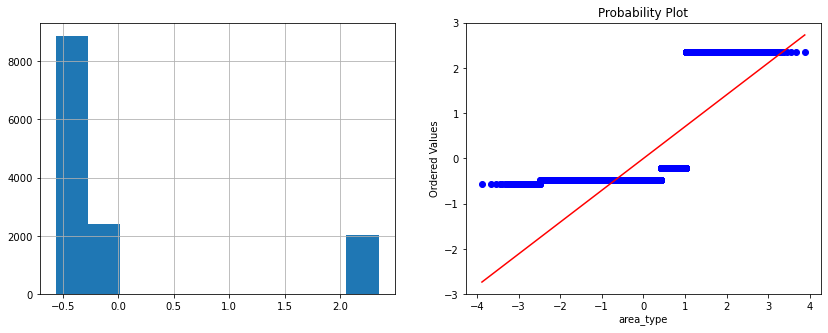

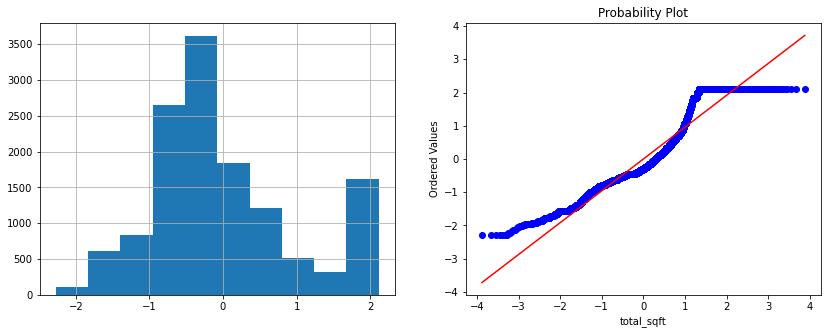

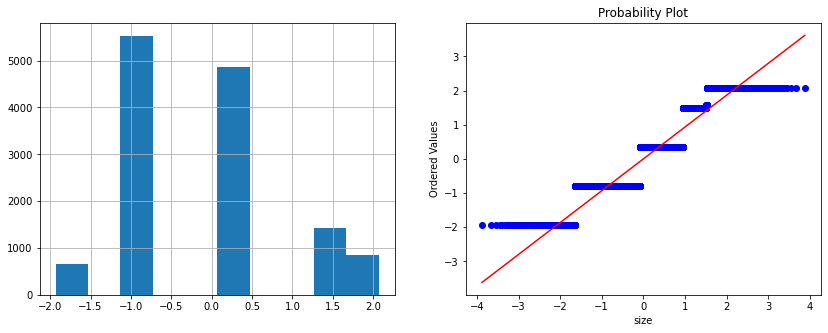

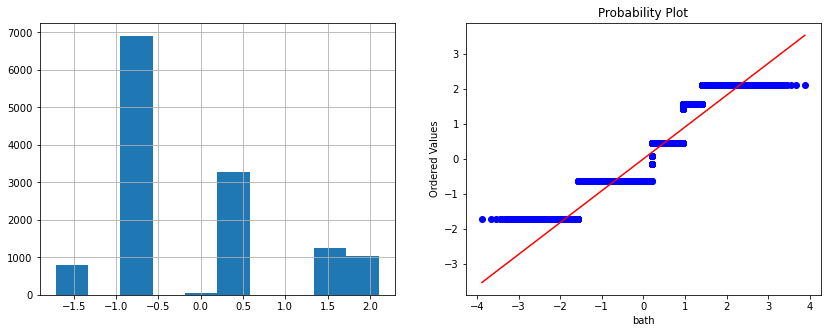

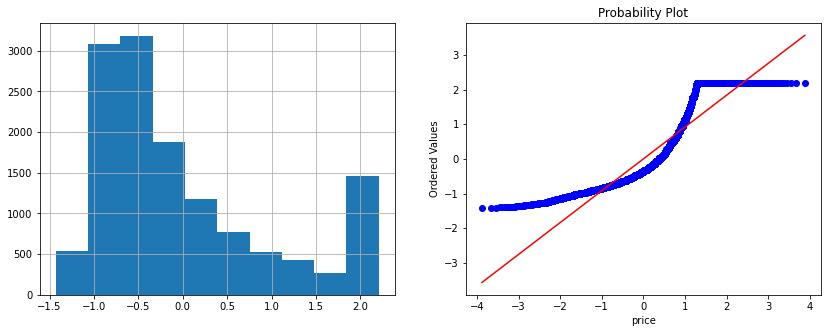

In [86]:
QQplot(df_scaled)

# <a>7. Linear Regression

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [93]:
X_train,X_test,Y_train,Y_test = train_test_split(df_scaled, df_new["price"], test_size = 0.25, random_state = 0)
lr = LinearRegression()
lin_model = lr.fit(X_train,Y_train)

In [95]:
print(lr.score(X_train,Y_train))
print(lr.score(X_test,Y_test))

1.0
1.0


In [96]:
def adj_r2(x,y):
    r2 = lr.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

print(adj_r2(X_train,Y_train))

print(adj_r2(X_test,Y_test))

1.0
1.0


In [97]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [98]:
Y_pred=lin_model.predict(X_test)

print(mean_squared_error(Y_pred,Y_test))
print(np.sqrt(mean_squared_error(Y_pred,Y_test)))

9.38199618329518e-29
9.68607050526434e-15


H:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

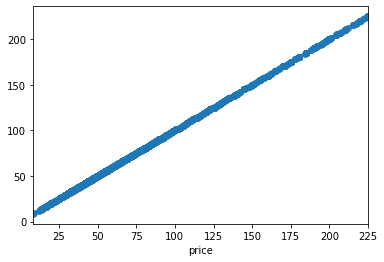

In [99]:
sns.regplot(Y_test,Y_pred)

H:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
H:\Anaconda\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

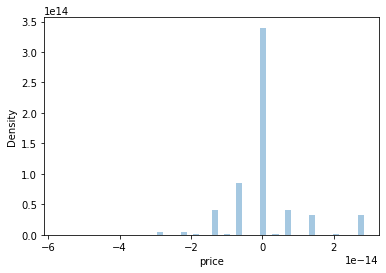

In [100]:
sns.distplot(Y_test-Y_pred)

In [101]:
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV

In [102]:
alphas = np.random.uniform(low = 0, high = 10000, size = (500,))
ridgecv = RidgeCV(alphas = alphas,cv = 10,normalize = True)
ridgecv.fit(X_train, Y_train)

RidgeCV(alphas=array([7.02079019e+03, 7.01993385e+03, 3.67275084e+03, 2.49698174e+03,
       4.07142125e+03, 5.47541311e+03, 8.98496930e+03, 8.05561163e+03,
       9.87748606e+03, 3.61208674e+03, 6.35700370e+00, 3.20215979e+03,
       7.09380244e+03, 2.08213934e+03, 1.72941377e+03, 5.99252423e+03,
       5.76706915e+03, 6.81870792e+02, 3.46336447e+03, 5.81379031e+03,
       6.56868563e+03, 2.37341024e+0...
       8.37456965e+02, 6.45109155e+02, 2.52366960e+03, 3.81203105e+03,
       6.53838121e+01, 9.62161543e+03, 1.19756624e+03, 7.10473613e+03,
       4.54224211e+03, 9.47012143e+02, 5.45534946e+03, 2.56657997e+03,
       3.90105496e+03, 3.55160130e+03, 1.79419932e+03, 6.05136826e+03,
       2.49911983e+03, 6.89742770e+03, 1.97737147e+03, 5.38408237e+03,
       6.51775019e+03, 1.34035381e+03, 3.11425207e+02, 4.81469188e+03]),
        cv=10, normalize=True)

In [103]:
ridgecv.alpha_

6.3570037033322535

In [104]:
ridge_model=Ridge(alpha=ridgecv.alpha_)
rid_model=ridge_model.fit(X_train,Y_train)

print(rid_model.score(X_train,Y_train))
print(rid_model.score(X_test,Y_test))

0.9999986634216691
0.9999985593769534


In [105]:
alphas = np.random.uniform(low=0, high=10000, size=(500,))
lassocv = LassoCV(alphas = None,cv=10,normalize = True,max_iter=10000)
lassocv.fit(X_train, Y_train)

LassoCV(cv=10, max_iter=10000, normalize=True)

In [106]:
lassocv.alpha_

0.000597906212867092

In [107]:
lasso_model=Lasso(alpha=lassocv.alpha_)
las_model=lasso_model.fit(X_train,Y_train)

print(las_model.score(X_train,Y_train))
print(las_model.score(X_test,Y_test))

0.9999999896472788
0.9999999888539179


In [108]:
elasticCV = ElasticNetCV(alphas = None , cv = 10, max_iter = 10000, normalize = True)
elasticCV.fit(X_train, Y_train)

ElasticNetCV(cv=10, max_iter=10000, normalize=True)

In [109]:
elasticCV.alpha_

0.0011958124257341843

In [110]:
elasticCV.l1_ratio

0.5

In [111]:
elastic_model=ElasticNet(alpha = elasticCV.alpha_,l1_ratio=0.5)
elas_model=elastic_model.fit(X_train, Y_train)

print(elas_model.score(X_train,Y_train))
print(elas_model.score(X_test,Y_test))

0.999998736125391
0.9999986363370373


In [112]:
Y_pred=lin_model.predict(X_test)

print(mean_squared_error(Y_pred,Y_test))
print(np.sqrt(mean_squared_error(Y_pred,Y_test)))

9.38199618329518e-29
9.68607050526434e-15


In [115]:
Y_pred=rid_model.predict(X_test)

print(mean_squared_error(Y_pred,Y_test))
print(np.sqrt(mean_squared_error(Y_pred,Y_test)))

0.005107405199814775
0.07146611224779738


In [116]:
Y_pred=las_model.predict(X_test)

print(mean_squared_error(Y_pred,Y_test))
print(np.sqrt(mean_squared_error(Y_pred,Y_test)))

3.9515928742043825e-05
0.006286169639935262


In [117]:
Y_pred=elas_model.predict(X_test)

print(mean_squared_error(Y_pred,Y_test))
print(np.sqrt(mean_squared_error(Y_pred,Y_test)))

0.004834560520646154
0.06953100402443613
